# Main-sequence of star-forming galaxies
In this notebook, we plot the "main-sequence of star forming galaxies" from observational data ([Chang et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJS..219....8C/abstract)) and normally assumed fits ([Speagle et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJS..214...15S/abstract) and [Leslie et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...899...58L/abstract)). First, we import the Python packages.

In [1]:
import warnings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerTuple

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from astroquery.vizier import Vizier

from astropy.cosmology import Planck13

import numpy as np

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)

In addition, we include a useful definition to truncate a colormap.

In [2]:
def truncate_colormap(colormap, minval=0.0, maxval=1.0, nspa=100):
    """Function found on stackoverflow.com: how-to-extract-a-subset-of-a-colormap-as-
    a-new-colormap-in-matplotlib"""
    new_colormap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(
            n=colormap.name, a=minval, b=maxval),
        colormap(np.linspace(minval, maxval, nspa)))
    return new_colormap

We also compare with the median values for the MS found by Chang et al. (2015, Eq.4). We add the estimations of the MS from Speagle et al. (2014) and Leslie et al. (2020) at  𝑧=0.1  which is similar to the median redshift in Chang et al. (2015).

In [3]:
def sfr_chang(stellar_mass):
    """MS defined by Chang et al. 2015"""
    return 0.8*(stellar_mass - 10) - 0.23


def sfr_speagle(m_stellar, time):
    """Time is Gyr and Stellar mass in solar masses from Speagle et al. (2014)"""
    return ((0.84 - 0.026*time) * np.log10(m_stellar)) - (6.51 - (0.11*time))


def sfr_leslie(m_stellar, time):
    """Time is Gyr and Stellar mass in log solar masses from Leslie et al. (2020)"""
    s0_val = 2.8
    a1_val = 0.23
    a2_val = 0.13
    m0_val = 10.8
    mturn = m0_val - a2_val*time
    return s0_val - a1_val*time - np.log10(1 + (10**mturn / 10**m_stellar))

## Standard Plot Format
Setup the standard plotting format and make the plot.

In [4]:
# graphic aspect ratio = width/height
ASPECT = 16.0/9.0

# Text width in inches - don't change, this is defined by the print layout
TEXTWIDTH = 5.14  # inches

# output format and resolution
FIG_FMT = 'pdf'
DPI = 300

# Graphic dimensions
PLT_W = DPI*TEXTWIDTH
PLT_H = PLT_W/ASPECT
AX_FONTSIZE = 10
LAB_FONTSIZE = 8
LWIDTH = 0.5
AX_PAD = 3
WINCHES = TEXTWIDTH
HINCHES = WINCHES/ASPECT

# LaTeX is used throughout for markup of symbols, Times-Roman serif font
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif',
       'serif': ['Times-Roman'], 'weight': 'bold', 'size': '16'})

# Font and line weight defaults for axes
matplotlib.rc('axes', linewidth=LWIDTH)
matplotlib.rcParams.update({'font.size': AX_FONTSIZE})

# axis and label padding
plt.rcParams['xtick.major.pad'] = f'{AX_PAD}'
plt.rcParams['ytick.major.pad'] = f'{AX_PAD}'
plt.rcParams['axes.labelpad'] = f'{AX_PAD}'

## Obtain the data from Chang+15

We set a the row limit to -1 to obtain all the rows in the catalog

In [5]:
Vizier.ROW_LIMIT = -1

We retrieve data from Chang et al. (2015) to compare data form the other estimations using SDSS+WISE. We select only the median estimated parameters to save memory.

In [6]:
Vizier_cols = Vizier(columns=['ID', 'RAJ2000', 'DEJ2000',
                              'z', 'lmass50', 'lsfr50'])
Vizier_cols.ROW_LIMIT = -1
Chang15 = Vizier_cols.get_catalogs('J/ApJS/219/8')[0]

Then, we remove data that is located in the lower limits of the estimations for SFR and stellar mass.

In [7]:
Chang15['lmass50'][Chang15['lmass50'] <= 7] = np.nan
Chang15['lmass50'][Chang15['lsfr50'] <= -5] = np.nan

##### Figure
We define a truncated colormap to plot the observational data

In [8]:
cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0.1, 0.95)

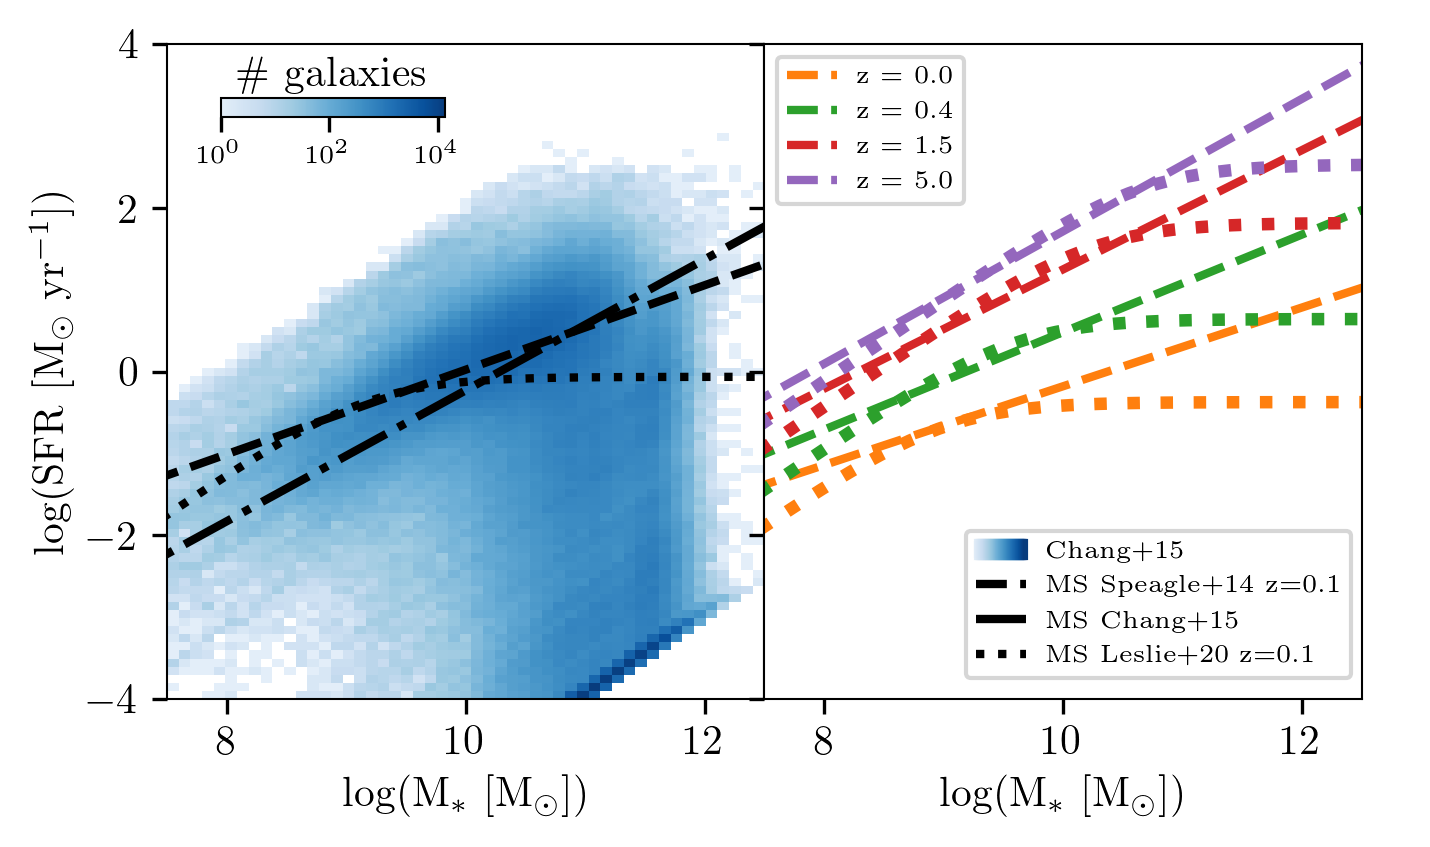

In [9]:
%matplotlib inline

common_mstar = np.linspace(7., 13)
patch_cmap = [patches.Patch(facecolor=c, edgecolor=c)
              for c in new_cmap(np.linspace(0, 1, 100))]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

fig.set_dpi(DPI)
fig.set_size_inches(WINCHES, HINCHES)

img = ax1.hist2d(Chang15["lmass50"], Chang15["lsfr50"], cmin=1,
                 bins=[51, 81], cmap=new_cmap, label='Chang+15 data',
                 # This define the limits
                 range=np.array([[7.5, 12.5], [-4, 4]]),
                 norm=colors.LogNorm(vmin=1))
cbar_ax = inset_axes(ax1, width="25%", height="3%",
                     bbox_to_anchor=(-1., -0.05, 1.5, 1),
                     bbox_transform=ax1.transAxes)
cb = plt.colorbar(img[3], orientation='horizontal', ticks=[1, 100, 10000],
                  cax=cbar_ax, label=r'\# galaxies')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=6)

ax1.plot(common_mstar,
         sfr_speagle(10**common_mstar,
                     Planck13.age(0.1).value),
         c='k', ls='--', lw=2,
         label='MS Speagle+14 z=0.1')
ax1.plot(common_mstar, sfr_chang(common_mstar),
         c='k', ls='-.', lw=2,
         label='MS Chang+15',)
ax1.plot(common_mstar,
         sfr_leslie(common_mstar, Planck13.age(0.1).value),
         label='MS Leslie+20 z=0.1', c='k', ls=':', lw=2)

ax1.set_xlabel(r'$\log$(M$_\ast$ [M$_\odot$])', fontsize=AX_FONTSIZE)
ax1.set_ylabel(r'$\log$(SFR [M$_\odot$ yr$^{-1}$])', fontsize=AX_FONTSIZE)
# ax1.legend(loc='upper left')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=[patch_cmap] + handles,
           labels=['Chang+15', labels[0], labels[1], labels[2]],
           handler_map={list: HandlerTuple(ndivide=None, pad=0)},
           loc=(0.675, 0.2), prop={'size': 6})

for idz, redshifts in enumerate([0, 0.4, 1.5, 5]):
    ax2.plot(common_mstar,
             sfr_speagle(10**common_mstar,
                         Planck13.age(redshifts).value),
             c='C'+str(idz+1), ls='--', lw=2,
             label='z = %.1f' % redshifts)
    ax2.plot(common_mstar,
             sfr_leslie(common_mstar, Planck13.age(redshifts).value),
             c='C'+str(idz+1), ls=':', lw=3)

ax2.set_xlabel(r'$\log$(M$_\ast$ [M$_\odot$])', fontsize=AX_FONTSIZE)
leg2 = ax2.legend(prop={'size': 6})
plt.setp(leg2.get_title(), fontsize=8)

plt.setp(ax2.get_yticklabels(), visible=False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../Figures/MainSequence.pdf', bbox_inches='tight',
            facecolor='white')  # For Paper

##### Notebook information

In [10]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w -p astroquery

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.59.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astroquery: 0.4.4

autopep8  : 1.5.7
matplotlib: 3.4.3
json      : 2.0.9
numpy     : 1.22.1

Watermark: 2.2.0

